In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install gtts pydub audioop-lts
from pydub import AudioSegment
import time
import os
import copy
import pandas as pd
from gtts import gTTS
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from moviepy import ImageClip, AudioFileClip
from utils_data import (
    load_raw_data, check_dups, filter_df_to_vocab_of_interest, 
    fill_default_settings
    )
from utils_video import (
    create_component_words_text, add_text_and_save_clip, determine_if_text_size_too_big, create_full_video_file
)
from utils_audio import (
    create_tts_files_for_one_vocab_word, load_audio, compute_pinyin_and_create_recordings,
    combine_audio_files_and_compute_durations, compute_start_times_for_clips
)
from video_file_configs.v005_one_hundred_words_six_minutes import (
    CHANNEL_TITLE, VIDEO_NUMBER, VIDEO_NAME, VIDEO_STRUCTURE,
    INTR_COUNT_STR, INTRO_DURATION_STR, FEEDBACK,
    nonvocab_audio_path, nonvocab_slides,
    dict_recordings,
    BG_SIZE, MAX_LINE_LENGTH_CONSTANT,
    TEXT_COLOR, BG_COLOR, TEXT_SPACING, TEXT_SPACING_COMPONENTS, MAX_LINE_LENGTH_CONSTANT, FONT_SIZES_BY_TYPE, hanzi_font_path,
    NONVOCAB_AUDIO_TEXT_FONT, NONVOCAB_AUDIO_TEXT_FILL,
    NONVOCAB_AUDIO_TEXT_SPACING, NONVOCAB_AUDIO_TEXT_ALIGN, NONVOCAB_AUDIO_TEXT_Y,
)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 130

# 0. Create dataframe of settings

In [3]:
# Create settings df
df_all_recordings_tomake = fill_default_settings(dict_recordings)

# Create folder for non-audio recordings for this project
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    # Create folder if not exists
    if not os.path.exists(f"{nonvocab_audio_path}/{rrow['recording_name']}"):
        os.mkdir(f"{nonvocab_audio_path}/{rrow['recording_name']}")

df_all_recordings_tomake

,recording_id,filename_suffix,min_adu,min_per,min_priority,max_priority,types_allowed,exclude_words,max_count,min_known_english_prompt,max_known_english_prompt,min_known_pinyin_prompt,max_known_pinyin_prompt,sort_keys,sort_asc,min_combo_quality,category_type,cat1_values_allowed,types_allowed_str,min_date,contains_character,categories_allowed,recording_name
0,chinese_only_word_twice,_one_hundred_words,3,3,1,1,"[combo, no combo, two word, prefix, single cha...","[最大的弱点, 大二, 大三, 大一, 台湾, 孔子, 普通话, 人民币, 随地吐痰, 被黑...",100,1,6,1,6,"[category1, category2, pinyin]","[True, True, True]",6,,None,,2025-01-01,None,None,0925_chinese_only_word_twice__one_hundred_words


In [4]:
# Delete old version, if desired
delete_old = False
if delete_old:
    if os.path.exists(f"{nonvocab_audio_path}/{rrow['recording_name']}/audio_durations_all.csv"):
        os.remove(f"{nonvocab_audio_path}/{rrow['recording_name']}/audio_durations_all.csv")
    if os.path.exists(f"{nonvocab_audio_path}/{rrow['recording_name']}/audio_durations_vocab_only.csv"):
        os.remove(f"{nonvocab_audio_path}/{rrow['recording_name']}/audio_durations_vocab_only.csv")
    if os.path.exists(f"{nonvocab_audio_path}/{rrow['recording_name']}/video.mp4"):
        os.remove(f"{nonvocab_audio_path}/{rrow['recording_name']}/video.mp4")
    if os.path.exists(f"{nonvocab_audio_path}/{rrow['recording_name']}/audio.mp3"):
        os.remove(f"{nonvocab_audio_path}/{rrow['recording_name']}/audio.mp3")
    

# 1. Load data

In [5]:
truly_load_data = False
if truly_load_data:
    df_all_vocab = load_raw_data()
    df_all_vocab.to_csv('latest_data.csv', index=False)
else:
    df_all_vocab = pd.read_csv('latest_data.csv')
    print('!!!!!!!! WARNING: not truly loading data !!!!!!!!')

df_dups = check_dups(df_all_vocab)
print(f'# duplicate vocab: {len(df_dups)}')
print(df_all_vocab.shape)
df_all_vocab.head(3)

!!!!!!!! WARNING: not truly loading data !!!!!!!!
# duplicate vocab: 0
(5362, 28)


,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1,per,adu
0,5082,耳机,ěr jī,headphones,combo,1.0,5.0,1.0,2.0,NaN,electronics,NaN,1.0,耳,ear,机,machine,NaN,NaN,NaN,NaN,我的耳机丢了,wǒ de ěrjī diū le,I lost my earphones,2025-09-07,daily add,5.0,5.0
1,4,组合,zǔ hé,combination,combo,1.0,5.0,3.0,4.0,NaN,general,NaN,2.0,组,set,合适,suitable,NaN,NaN,NaN,NaN,这个组合在比赛中获得了第一名。,Zhège zǔhé zài bǐsài zhōng huòdé le dì yī míng.,This group won first place in the competition.,2025-01-02,NaN,5.0,5.0
2,5179,密码,mì mǎ,password,combo,1.0,5.0,1.0,5.0,NaN,general,identity theft,2.0,秘密,secret,码,code,NaN,NaN,NaN,NaN,不要把密码告诉别人,bù yào bǎ mì mǎ gào sù bié rén,do not tell others your password,2025-09-10,chatgpt,5.0,5.0


# 2. Select data

In [6]:
dfs_vocab_lists = {}
n_vocab_by_recording = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    dfs_vocab_lists[rrow['recording_name']] = filter_df_to_vocab_of_interest(df_all_vocab, rrow)
    n_vocab_by_recording[rrow['recording_name']] = len(dfs_vocab_lists[rrow['recording_name']])
    print(rrow['recording_name'], n_vocab_by_recording[rrow['recording_name']])

dfs_vocab_lists[rrow['recording_name']].head(3)

0925_chinese_only_word_twice__one_hundred_words 100


,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1,per,adu
0,1039,标准,biāo zhǔn,standard,combo,1.0,5.0,1.0,1.0,NaN,adjective,NaN,3.0,目标,target,准备,preparation,NaN,NaN,NaN,NaN,这家店的服务很标准,Zhè jiā diàn de fúwù hěn biāozhǔn,The service here is very standard,2025-01-02,NaN,5.0,5.0
1,128,具体,jù tǐ,specific;concrete;definite,combo,1.0,3.0,1.0,2.0,NaN,adjective,NaN,3.0,具,tool,身体,body,NaN,NaN,NaN,NaN,能说得具体一点吗,Néng shuō de jùtǐ yīdiǎn ma,Can you be more specific,2025-01-02,NaN,5.0,5.0
2,1643,详细,xiáng xì,detailed,no combo,1.0,5.0,3.0,5.0,NaN,adjective,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,请给我详细地址,Qǐng gěi wǒ xiángxì dìzhǐ,Please give me the detailed address,2025-01-02,NaN,5.0,5.0


# 3. Create vocabulary audio recordings

In [7]:
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    if rrow['recording_id'] == '005':
        dfs_vocab_lists[rrow['recording_name']] = compute_pinyin_and_create_recordings(dfs_vocab_lists[rrow['recording_name']])
    for i_row, row in dfs_vocab_lists[rrow['recording_name']].iterrows():
        print(f'{rrow['recording_name']} row{i_row}')
        create_tts_files_for_one_vocab_word(row, rrow)

0925_chinese_only_word_twice__one_hundred_words row0
0.000s, ALREADY EXISTS, zh, 标准
0.000s, ALREADY EXISTS, zh_slow, 标准
0.000s, ALREADY EXISTS, english, standard
0925_chinese_only_word_twice__one_hundred_words row1
0.000s, ALREADY EXISTS, zh, 具体
0.000s, ALREADY EXISTS, zh_slow, 具体
0.000s, ALREADY EXISTS, english, specific;concrete;definite
0925_chinese_only_word_twice__one_hundred_words row2
0.000s, ALREADY EXISTS, zh, 详细
0.000s, ALREADY EXISTS, zh_slow, 详细
0.000s, ALREADY EXISTS, english, detailed
0925_chinese_only_word_twice__one_hundred_words row3
0.000s, ALREADY EXISTS, zh, 正常
0.000s, ALREADY EXISTS, zh_slow, 正常
0.000s, ALREADY EXISTS, english, normal
0925_chinese_only_word_twice__one_hundred_words row4
0.000s, ALREADY EXISTS, zh, 脏
0.000s, ALREADY EXISTS, zh_slow, 脏
0.000s, ALREADY EXISTS, english, dirty
0925_chinese_only_word_twice__one_hundred_words row5
0.000s, ALREADY EXISTS, zh, 非常
0.000s, ALREADY EXISTS, zh_slow, 非常
0.000s, ALREADY EXISTS, english, very
0925_chinese_only_wor

## 3b. Compute durations of combined audios for each vocab word

In [8]:
df_vocab_audio_durations = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    audio_duration_file_name = f"{nonvocab_audio_path}/{rrow['recording_name']}/audio_durations_vocab_only.csv"
    if os.path.exists(audio_duration_file_name):
        df_vocab_audio_durations[rrow['recording_name']] = pd.read_csv(audio_duration_file_name)
        print(f"Loaded existing audio durations for {rrow['recording_name']}, shape {df_vocab_audio_durations[rrow['recording_name']].shape}")
    else:
        df_vocab_audio_durations[rrow['recording_name']] = combine_audio_files_and_compute_durations(dfs_vocab_lists[rrow['recording_name']], rrow)
        df_vocab_audio_durations[rrow['recording_name']].to_csv(audio_duration_file_name, index=False)

    df_vocab_audio_durations[rrow['recording_name']]['nonvocab_file_path'] = None
    df_vocab_audio_durations[rrow['recording_name']]['nonvocab_pause_ms'] = None
    df_vocab_audio_durations[rrow['recording_name']]['nonvocab_key'] = None
print(f"Total duration: {df_vocab_audio_durations[rrow['recording_name']]['combined'].sum()}s")
df_vocab_audio_durations[rrow['recording_name']].head(3)

0.42 seconds, recid0925_chinese_only_word_twice__one_hundred_words, row 0, 标准
0.35 seconds, recid0925_chinese_only_word_twice__one_hundred_words, row 1, 具体
0.35 seconds, recid0925_chinese_only_word_twice__one_hundred_words, row 2, 详细
0.36 seconds, recid0925_chinese_only_word_twice__one_hundred_words, row 3, 正常
0.35 seconds, recid0925_chinese_only_word_twice__one_hundred_words, row 4, 脏
0.36 seconds, recid0925_chinese_only_word_twice__one_hundred_words, row 5, 非常
0.35 seconds, recid0925_chinese_only_word_twice__one_hundred_words, row 6, 刚好
0.36 seconds, recid0925_chinese_only_word_twice__one_hundred_words, row 7, 宽
0.35 seconds, recid0925_chinese_only_word_twice__one_hundred_words, row 8, 水平
0.36 seconds, recid0925_chinese_only_word_twice__one_hundred_words, row 9, 窄
0.35 seconds, recid0925_chinese_only_word_twice__one_hundred_words, row 10, 至少
0.35 seconds, recid0925_chinese_only_word_twice__one_hundred_words, row 11, 通常
0.35 seconds, recid0925_chinese_only_word_twice__one_hundred_word

,chinese,pinyin,english,d_chinese,rel_start_chinese,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key
0,标准,biāo zhǔn,standard,2.892,0,3.892,3.64175,None,None,None
1,具体,jù tǐ,specific;concrete;definite,2.772,0,3.772,3.52175,None,None,None
2,详细,xiáng xì,detailed,2.868,0,3.868,3.61775,None,None,None


# 4. Create non-vocab audio recordings

In [9]:
audio_filler_variables = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    # Fill nonvocab audio recordings with data from vocab, if needed
    # Define audio variables
    audio_filler_variables[rrow['recording_name']] = {
        'audio_duration_minutes': df_vocab_audio_durations[rrow['recording_name']]['combined'].sum() / 60,
        'n_vocab': len(df_vocab_audio_durations[rrow['recording_name']]),
    }

    # Fill text for audio recordings
    for nv_name, nv_settings in nonvocab_slides.items():
        if 'chinese' not in nv_settings.keys():
            nonvocab_slides[nv_name]['chinese'] = nv_settings['chinese_unfill'].format(**audio_filler_variables[rrow['recording_name']])
            nonvocab_slides[nv_name]['pinyin'] = nv_settings['pinyin_unfill'].format(**audio_filler_variables[rrow['recording_name']])
            nonvocab_slides[nv_name]['english'] = nv_settings['english_unfill'].format(**audio_filler_variables[rrow['recording_name']])

    # Generate non-vocab recording
    for nv_name, nv_settings in nonvocab_slides.items():
        # Generate audio if not already exists
        nv_settings['file_path'] = f"{nonvocab_audio_path}/{rrow['recording_name']}/{nv_settings['chinese']}.mp3"
        if not os.path.exists(nv_settings['file_path']):
            gTTS(nv_settings['chinese'], lang='zh').save(nv_settings['file_path'])
            print(f'Generated {nv_settings['chinese']}')
        else:
            print(f'{nv_name} audio already generated: {nv_settings['chinese']}')

        # Insert audio duration into `df_vocab_audio_durations`
        if nv_settings['change_index'] is None:
            nv_settings['change_index'] = len(df_vocab_audio_durations[rrow['recording_name']])

        df_vocab_audio_durations[rrow['recording_name']].loc[nv_settings['change_index']] = pd.Series({
            'chinese': nv_settings['chinese'],
            'pinyin': nv_settings['pinyin'],
            'english': nv_settings['english'],
            'combined': AudioFileClip(nv_settings['file_path']).duration + nv_settings['pause_ms']/1000,
            'nonvocab_file_path': nv_settings['file_path'],
            'nonvocab_pause_ms': nv_settings['pause_ms'],
            'nonvocab_key': nv_name,
            })

    # Fix indices after adding in non-vocab audio
    df_vocab_audio_durations[rrow['recording_name']].index = df_vocab_audio_durations[rrow['recording_name']].index + 1
    df_vocab_audio_durations[rrow['recording_name']] = df_vocab_audio_durations[rrow['recording_name']].sort_index().reset_index(drop=True)

    # Compute timestamps for starting each clip
    df_vocab_audio_durations[rrow['recording_name']]['end'] = df_vocab_audio_durations[rrow['recording_name']]['combined'].cumsum()
    df_vocab_audio_durations[rrow['recording_name']]['start'] = df_vocab_audio_durations[rrow['recording_name']]['end'] - df_vocab_audio_durations[rrow['recording_name']]['combined']
    if rrow['recording_id'] in ['004', '008', '010', '014', '016']:
        df_vocab_audio_durations[rrow['recording_name']]['start_chinese'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_chinese']
        df_vocab_audio_durations[rrow['recording_name']]['start_english'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_english']
    elif rrow['recording_id'] == '013':
        df_vocab_audio_durations[rrow['recording_name']]['start_chinese'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_chinese']
        df_vocab_audio_durations[rrow['recording_name']]['start_component_words'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_component_words']
        df_vocab_audio_durations[rrow['recording_name']]['start_english'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_english']
        df_vocab_audio_durations[rrow['recording_name']]['start_sent'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_sent']
        df_vocab_audio_durations[rrow['recording_name']]['start_sent_english'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_sent_english']
    elif rrow['recording_id'] == '006':
        df_vocab_audio_durations[rrow['recording_name']]['start_chinese'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_chinese']
        df_vocab_audio_durations[rrow['recording_name']]['start_component_words'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_component_words']
        df_vocab_audio_durations[rrow['recording_name']]['start_english'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_english']
    elif rrow['recording_id'] == '001':
        df_vocab_audio_durations[rrow['recording_name']]['start_chinese'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_chinese']
        df_vocab_audio_durations[rrow['recording_name']]['start_english'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_english']
        df_vocab_audio_durations[rrow['recording_name']]['start_sent'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_sent']
        df_vocab_audio_durations[rrow['recording_name']]['start_sent_english'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_sent_english']
    elif rrow['recording_id'] == '012':
        df_vocab_audio_durations[rrow['recording_name']]['start_english'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_english']
        df_vocab_audio_durations[rrow['recording_name']]['start_chinese'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_chinese']
        df_vocab_audio_durations[rrow['recording_name']]['start_sent'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_sent']
    elif rrow['recording_id'] == '015':
        df_vocab_audio_durations[rrow['recording_name']]['start_sent'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_sent']
    elif rrow['recording_id'] in ['chinese_only_word_twice']:
        pass
    else:
        raise ValueError(f"Unsupported recording id {rrow['recording_id']}")
    
    # Save durations dataframe with static audio as a csv
    df_vocab_audio_durations[rrow['recording_name']].to_csv(f"{nonvocab_audio_path}/{rrow['recording_name']}/audio_durations_all.csv", index=False)

    # Update nonvocab_slide settings info with duration and start
    for i_row, row in df_vocab_audio_durations[rrow['recording_name']].iterrows():
        if row['nonvocab_key'] is not None:
            nonvocab_slides[row['nonvocab_key']]['duration'] = row['combined']
            nonvocab_slides[row['nonvocab_key']]['start'] = row['start']

df_vocab_audio_durations[rrow['recording_name']].head(10)

Generated 欢迎观看我的普通话数据库视频 5: 100 常用词: 6 分钟
Generated 如果你有任何问题、建议或反馈，请留言。


,chinese,pinyin,english,d_chinese,rel_start_chinese,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start
0,欢迎观看我的普通话数据库视频 5: 100 常用词: 6 分钟,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,8.39000,audio_files/files_by_video//0925_chinese_only_...,300,intro,8.39000,0.00000
1,标准,biāo zhǔn,standard,2.892,0.0,3.892,3.64175,None,None,None,12.03175,8.39000
2,具体,jù tǐ,specific;concrete;definite,2.772,0.0,3.772,3.52175,None,None,None,15.55350,12.03175
3,详细,xiáng xì,detailed,2.868,0.0,3.868,3.61775,None,None,None,19.17125,15.55350
4,正常,zhèng ​cháng,normal,2.988,0.0,3.988,3.73775,None,None,None,22.90900,19.17125
5,脏,zàng,dirty,2.196,0.0,3.196,2.94575,None,None,None,25.85475,22.90900
6,非常,fēi cháng,very,3.036,0.0,4.036,3.78575,None,None,None,29.64050,25.85475
7,刚好,gāng hǎo,just;exactly;happen to,2.772,0.0,3.772,3.52175,None,None,None,33.16225,29.64050
8,宽,kuān,wide,2.292,0.0,3.292,3.04175,None,None,None,36.20400,33.16225
9,水平,shuǐ píng,level;standard,2.988,0.0,3.988,3.73775,None,None,None,39.94175,36.20400


# 5. Combine individual vocab into final audio recording

In [10]:
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    start_time = time.time()
    # Construct list of individual audio files
    all_audio_files = []
    for i_row, row in df_vocab_audio_durations[rrow['recording_name']].iterrows():
        if row['nonvocab_file_path'] is not None:
            all_audio_files.append(AudioSegment.from_mp3(row['nonvocab_file_path']))
            all_audio_files.append(AudioSegment.silent(duration=row['nonvocab_pause_ms']))
        else:
            # vocab
            all_audio_files.append(AudioSegment.from_mp3(f"audio_files/rows/{rrow['recording_id']}/{row['chinese']}.mp3"))

    # Construct and export whole audio file
    audio_concat = all_audio_files[0]
    for audio in all_audio_files[1:]:
        audio_concat += audio
    audio_concat.export(f"{nonvocab_audio_path}{rrow['recording_name']}/audio.mp3", format="mp3")
    print(f"{(time.time()-start_time):.2f}s, {nonvocab_audio_path}{rrow['recording_name']}/audio.mp3")

8.70s, audio_files/files_by_video/0925_chinese_only_word_twice__one_hundred_words/audio.mp3


# 6. Create images for video

In [11]:
# Load audio data, already computed above
# If using premade audio to make a video, then just run this:
df_audio_durations = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    try:
        df_audio_durations[rrow['recording_name']] = pd.read_csv(f"{nonvocab_audio_path}/{rrow['recording_name']}/audio_durations_all.csv")
        print(f"{rrow['recording_name']} loaded")
    except FileNotFoundError:
        print(f"File not found for recording {rrow['recording_name']}, please run the cell above to generate audio durations.")
df_audio_durations[rrow['recording_name']].head()

0925_chinese_only_word_twice__one_hundred_words loaded


,chinese,pinyin,english,d_chinese,rel_start_chinese,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start
0,欢迎观看我的普通话数据库视频 5: 100 常用词: 6 分钟,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,8.39000,audio_files/files_by_video//0925_chinese_only_...,300.0,intro,8.39000,0.00000
1,标准,biāo zhǔn,standard,2.892,0.0,3.892,3.64175,NaN,NaN,NaN,12.03175,8.39000
2,具体,jù tǐ,specific;concrete;definite,2.772,0.0,3.772,3.52175,NaN,NaN,NaN,15.55350,12.03175
3,详细,xiáng xì,detailed,2.868,0.0,3.868,3.61775,NaN,NaN,NaN,19.17125,15.55350
4,正常,zhèng ​cháng,normal,2.988,0.0,3.988,3.73775,NaN,NaN,NaN,22.90900,19.17125


## 6a. Vocab words

0925_chinese_only_word_twice__one_hundred_words; 0: 标准
0925_chinese_only_word_twice__one_hundred_words; 1: 具体
0925_chinese_only_word_twice__one_hundred_words; 2: 详细
0925_chinese_only_word_twice__one_hundred_words; 3: 正常
0925_chinese_only_word_twice__one_hundred_words; 4: 脏
0925_chinese_only_word_twice__one_hundred_words; 5: 非常
0925_chinese_only_word_twice__one_hundred_words; 6: 刚好
0925_chinese_only_word_twice__one_hundred_words; 7: 宽
0925_chinese_only_word_twice__one_hundred_words; 8: 水平
0925_chinese_only_word_twice__one_hundred_words; 9: 窄
0925_chinese_only_word_twice__one_hundred_words; 10: 至少
0925_chinese_only_word_twice__one_hundred_words; 11: 通常
0925_chinese_only_word_twice__one_hundred_words; 12: 偶尔
0925_chinese_only_word_twice__one_hundred_words; 13: 蚊子
0925_chinese_only_word_twice__one_hundred_words; 14: 动物
0925_chinese_only_word_twice__one_hundred_words; 15: 毕业
0925_chinese_only_word_twice__one_hundred_words; 16: 创业
0925_chinese_only_word_twice__one_hundred_words; 17: 队友
0925_


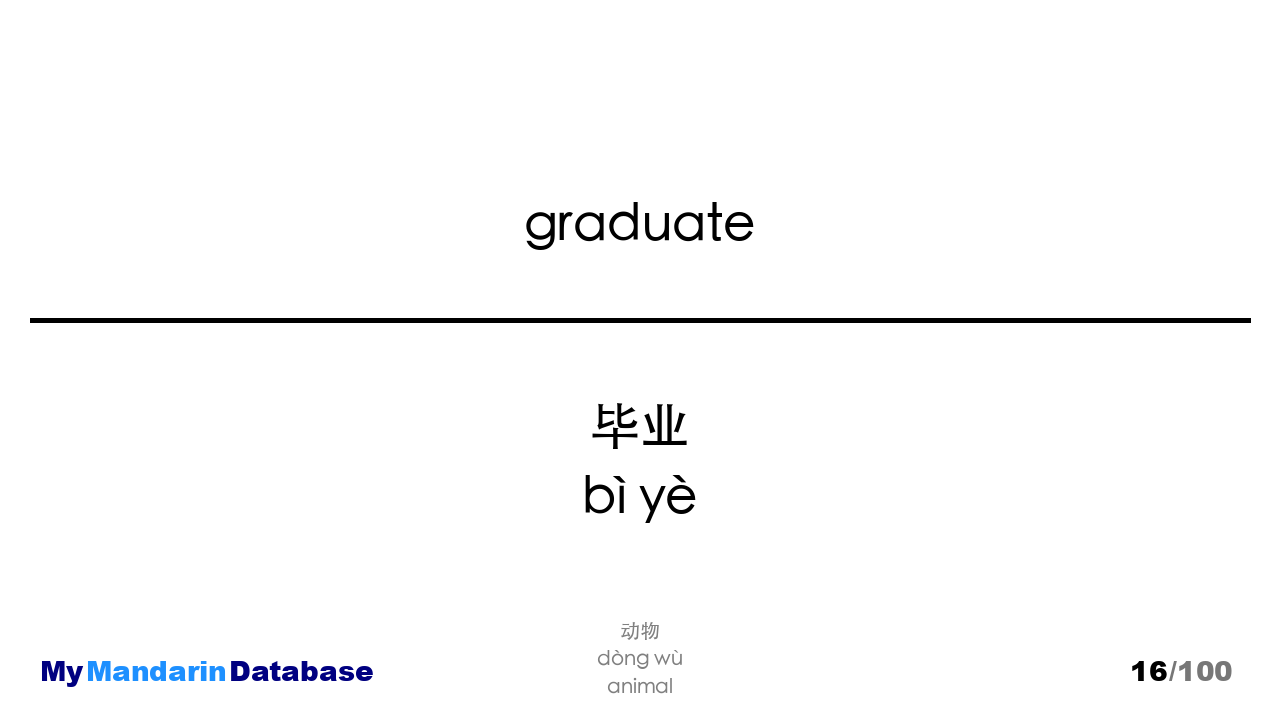

In [12]:
# Create all clips
clips = {}

for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    # Overall initializations
    previous_word = ''
    previous_sent = ''
    if not os.path.exists(f"audio_files/img_for_video/{rrow['recording_id']}"):
        os.mkdir(f"audio_files/img_for_video/{rrow['recording_id']}")
    clips[rrow['recording_name']] = []
    df_all_words = df_audio_durations[rrow['recording_name']].dropna(subset='sum_theory').reset_index(drop=True)

    for idx, row in df_all_words.iterrows():
        # Initialize image
        current_image_file_path = f"audio_files/img_for_video/{rrow['recording_id']}/{row['chinese']}"
        img = Image.new("RGB", BG_SIZE, color=BG_COLOR)
        draw = ImageDraw.Draw(img)

        # Header text
        
        # Footer text
        use_old_footer = False
        if use_old_footer:
            WORD_INDEX_RIGHT_SIDE_OFFSET = 180
            draw.text(text=f"{idx+1}/{n_vocab_by_recording[rrow['recording_name']]}", xy=(BG_SIZE[0] - WORD_INDEX_RIGHT_SIDE_OFFSET, 40)
                        , font=ImageFont.truetype('Arial Black', 44), fill = 'black', align='center')
            
            draw.multiline_text(
                xy=(BG_SIZE[0] - 140, BG_SIZE[1] - 100)
                , text='My\nMandarin\nDatabase'
                , font=ImageFont.truetype(hanzi_font_path, 26)
                , fill='gray', spacing=2, align='right'
                , stroke_width=1, stroke_fill='blue'
                )
            
            if previous_word != '':
                draw.multiline_text(
                    xy=(40, BG_SIZE[1] - 100)
                    , text=previous_word
                    , font=ImageFont.truetype(hanzi_font_path, 20)
                    , fill='gray', spacing=10, align='left'
                    )

            if previous_sent != '':
                sent_font = ImageFont.truetype(hanzi_font_path, 20)
                longest_length = max([sent_font.getlength(x) for x in previous_sent.split('\n')])
                draw.multiline_text(
                    xy=(BG_SIZE[0]/2 - longest_length/2, BG_SIZE[1] - 100)
                    , text=previous_sent
                    , font=sent_font
                    , fill='gray', spacing=10, align='center'
                    )
    
        else:
            LOGO_X_START = 40
            LOGO_Y_START = 70
            LOGO_FONT_SIZE = 28
            LOGO_FONT = 'Arial Black'
            WORD_INDEX_Y_START = LOGO_Y_START
            WORD_INDEX_FONT_SIZE = LOGO_FONT_SIZE
            WORD_INDEX_FONT = LOGO_FONT
            WORD_INDEX_RIGHT_SIDE_OFFSET = 150
            word_index_color_hex = "#000000"
            word_index2_color_hex ="#777777"
            
            word_index_font = ImageFont.truetype(WORD_INDEX_FONT, WORD_INDEX_FONT_SIZE)
            word_index_start_length = word_index_font.getlength(f"{idx+1}")
            draw.text(text=f"{idx+1}", xy=(BG_SIZE[0] - WORD_INDEX_RIGHT_SIDE_OFFSET, BG_SIZE[1] - WORD_INDEX_Y_START)
                        , font=word_index_font, fill = word_index_color_hex, align='center')
            draw.text(text=f"/{n_vocab_by_recording[rrow['recording_name']]}", xy=(BG_SIZE[0] - WORD_INDEX_RIGHT_SIDE_OFFSET + word_index_start_length + 2, BG_SIZE[1] - WORD_INDEX_Y_START)
                        , font=word_index_font, fill = word_index2_color_hex, align='center')
            
            logo_my_color_hex = "#000080"
            logo_mandarin_color_hex = "#1E90FF"
            logo_font = ImageFont.truetype(LOGO_FONT, LOGO_FONT_SIZE)
            logo_my_length = logo_font.getlength('My')
            logo_mandarin_length = logo_font.getlength('Mandarin')
            draw.text(
                xy=(LOGO_X_START, BG_SIZE[1] - LOGO_Y_START)
                , text='My'
                , font=logo_font
                , fill=logo_my_color_hex, align='left'
                )
            draw.text(
                xy=(LOGO_X_START + logo_my_length + 2, BG_SIZE[1] - LOGO_Y_START)
                , text='Mandarin'
                , font=logo_font
                , fill=logo_mandarin_color_hex, align='left'
                )
            draw.text(
                xy=(LOGO_X_START + logo_my_length + logo_mandarin_length + 4, BG_SIZE[1] - LOGO_Y_START)
                , text='Database'
                , font=logo_font
                , fill=logo_my_color_hex, align='left'
                )
            
            if previous_word != '':
                word_font = ImageFont.truetype(hanzi_font_path, 20)
                longest_length = max([word_font.getlength(x) for x in previous_word.split('\n')])
                draw.multiline_text(
                    xy=(BG_SIZE[0]/2 - longest_length/2, BG_SIZE[1] - 100)
                    , text=previous_word
                    , font=word_font
                    , fill='gray', spacing=10, align='center'
                    )
            
        # Update previous
        previous_word = f"{row['chinese']}\n{row['pinyin']}\n{row['english']}"
        if rrow['recording_id'] in ['013']:
            previous_sent = f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}"
            
        # Determine font size for component words
        if rrow['recording_id'] in ['013']:
            if not pd.isna(row['word4']):
                font_size_components = FONT_SIZES_BY_TYPE['components'] * .5
            elif not pd.isna(row['word3']):
                font_size_components = FONT_SIZES_BY_TYPE['components'] * .75
            else:
                font_size_components = FONT_SIZES_BY_TYPE['components']

        # Write vocab depending on recording ID
        if rrow['recording_id'] == '013':
            # Establish texts
            texts = {
                'chinese': {
                    'text': f"{row['chinese']} ({row['pinyin']})",
                    'y_pos': 50,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['words'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': row['start_component_words'] - row['start_chinese'],
                    'timestamp_start': row['start_chinese'],
                    'img_file_suffix': '_chinese',
                    },
                'component_words': {
                    'text': create_component_words_text(row),
                    'y_pos': 220,
                    'font_path': hanzi_font_path,
                    'font_size': font_size_components,
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING_COMPONENTS,
                    'align': 'center',
                    'duration': row['start_english'] - row['start_component_words'],
                    'timestamp_start': row['start_component_words'],
                    'img_file_suffix': '_component_words',
                    },
                'english': {
                    'text': row['english'],
                    'y_pos': 250,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['words'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': row['start_sent'] - row['start_english'],
                    'timestamp_start': row['start_english'],
                    'img_file_suffix': '_component_words_english',
                    },
                'sentence_chinese': {
                    'text': row['sentence'],
                    'y_pos': 370,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['sent_chinese'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': None,
                    'timestamp_start': None,
                    'img_file_suffix': None,
                    },
                'sentence_pinyin': {
                    'text': row['sentence_pinyin'],
                    'y_pos': 440,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['sent'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': row['start_sent_english'] - row['start_sent'],
                    'timestamp_start': row['start_sent'],
                    'img_file_suffix': '_sentence',
                    },
                'sentence_english': {
                    'text': row['sentence_english'],
                    'y_pos': 510,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['sent'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': row['end'] - row['start_sent_english'],
                    'timestamp_start': row['start_sent_english'],
                    'img_file_suffix': '_sentence_e',
                    },
            }

            # Add each text and create a new clip as appropriate
            img, draw, clips = add_text_and_save_clip(texts['chinese'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)
            img, draw, clips = add_text_and_save_clip(texts['component_words'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)
            img, draw, clips = add_text_and_save_clip(texts['english'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)
            draw.line([(30, 330), (BG_SIZE[0] - 30, 330)], fill='black', width=5, joint=None)
            img, draw, clips = add_text_and_save_clip(texts['sentence_chinese'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path, save_clip=False)
            img, draw, clips = add_text_and_save_clip(texts['sentence_pinyin'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)
            img, draw, clips = add_text_and_save_clip(texts['sentence_english'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)
        
        elif rrow['recording_id'] in ['016']:
            texts = {
                'english': {
                    'text': row['english'],
                    'y_pos': 200,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['words'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': row['start_chinese'] - row['start'],
                    'timestamp_start': row['start'],
                    'img_file_suffix': '_english',
                    },
                'chinese': {
                    'text': f"{row['chinese']}\n{row['pinyin']}",
                    'y_pos': 400,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['words'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': row['end'] - row['start_chinese'],
                    'timestamp_start': row['start_chinese'],
                    'img_file_suffix': '_chinese',
                    },
            }

            # Add each text and create a new clip as appropriate
            img, draw, clips = add_text_and_save_clip(texts['english'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)
            draw.line([(30, 320), (BG_SIZE[0] - 30, 320)], fill='black', width=5, joint=None)
            img, draw, clips = add_text_and_save_clip(texts['chinese'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)
        
        elif rrow['recording_id'] in ['chinese_only_word_twice']:
            texts = {
                'english': {
                    'text': row['english'],
                    'y_pos': 200,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['words'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': None,
                    'timestamp_start': None,
                    'img_file_suffix': None,
                    },
                'chinese': {
                    'text': f"{row['chinese']}\n{row['pinyin']}",
                    'y_pos': 400,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['words'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': row['end'] - row['start'],
                    'timestamp_start': row['start'],
                    'img_file_suffix': '_slide_all',
                    },
            }

            # Add each text and create a new clip as appropriate
            img, draw, clips = add_text_and_save_clip(texts['english'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path, save_clip=False)
            draw.line([(30, 320), (BG_SIZE[0] - 30, 320)], fill='black', width=5, joint=None)
            img, draw, clips = add_text_and_save_clip(texts['chinese'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)

        
        # elif rrow['recording_id'] == '006':
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}", row['start_component_words'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
        #     component_words_text = create_component_words_text(row)
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}\n{component_words_text}", row['start_english'] - row['start_component_words'], row['start_component_words'], f"{rrow['recording_id']}/{row['chinese']}_component_words"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}\n{component_words_text}\n{row['english']}", row['end'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_component_words_english"))
        
        # elif rrow['recording_id'] == '001':
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']} ({row['pinyin']})", row['start_english'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']} ({row['pinyin']}): {row['english']}", row['start_sent'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_english"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}", row['start_sent_english'] - row['start_sent'], row['start_sent'], f"{rrow['recording_id']}/{row['chinese']}_sentence"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['end'] - row['start_sent_english'], row['start_sent_english'], f"{rrow['recording_id']}/{row['chinese']}_sentence_e"))
        
        # elif rrow['recording_id'] == '012':
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['english']}", row['start_chinese'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_english"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['english']}\n{row['chinese']} ({row['pinyin']})", row['start_sent'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['end'] - row['start_sent'], row['start_sent'], f"{rrow['recording_id']}/{row['chinese']}_sentence"))
        
        # elif rrow['recording_id'] in ['004', '008', '010', '014']:
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}", row['start_english'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']} ({row['pinyin']})\n{row['english']}", row['end'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_english"))
        
        # elif rrow['recording_id'] in ['015']:
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']} ({row['pinyin']}): {row['english']}\n --------- \n{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['end'] - row['start'], row['start'], f"{rrow['recording_id']}/{row['chinese']}"))
        
        else:
            raise ValueError(f"Unknown vlaue of recording_id: {rrow['recording_id']}")
        
        print(f'{rrow['recording_name']}; {idx}: {row["chinese"]}')

clips[rrow['recording_name']][15].display_in_notebook()

## 6b. Intro slide


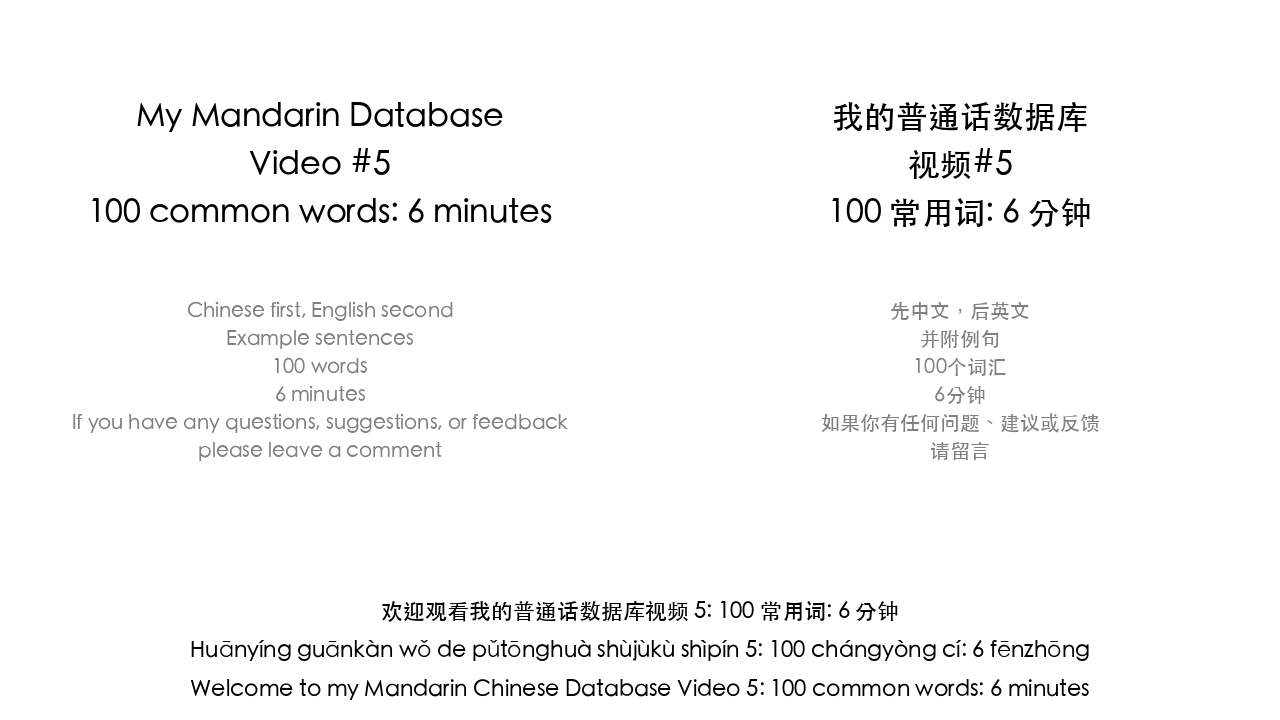

In [13]:
intro_texts_dict = [
    {'text': f'{CHANNEL_TITLE[0]}\n{VIDEO_NUMBER[0]}\n{VIDEO_NAME[0]}',
     'text_chinese': f'{CHANNEL_TITLE[1]}\n{VIDEO_NUMBER[1]}\n{VIDEO_NAME[1]}',
     'font': ImageFont.truetype(hanzi_font_path, 32),
     'fill': 'black',
     'spacing': 20,
     'align': 'center',
     'y': 100,
     },
    {'text': f'{VIDEO_STRUCTURE[0]}\n{INTR_COUNT_STR[0].format(n_vocab_words=audio_filler_variables[rrow['recording_name']]['n_vocab'])}\n{INTRO_DURATION_STR[0].format(audio_duration_minutes=audio_filler_variables[rrow['recording_name']]['audio_duration_minutes'])}\n{FEEDBACK[0]}',
     'text_chinese': f'{VIDEO_STRUCTURE[1]}\n{INTR_COUNT_STR[1].format(n_vocab_words=audio_filler_variables[rrow['recording_name']]['n_vocab'])}\n{INTRO_DURATION_STR[1].format(audio_duration_minutes=audio_filler_variables[rrow['recording_name']]['audio_duration_minutes'])}\n{FEEDBACK[1]}',
     'font': ImageFont.truetype(hanzi_font_path, 20),
     'fill': 'gray',
     'spacing': 10,
     'align': 'center',
     'y': 300,
     },
]

# Initialize image
img = Image.new("RGB", BG_SIZE, color=BG_COLOR)
draw = ImageDraw.Draw(img)

# Write title in english and chinese
for i_ts, text_settings in enumerate(intro_texts_dict):
    intro_texts_dict[i_ts]['length'] = max([text_settings['font'].getlength(x) for x in text_settings['text'].split('\n')])
    intro_texts_dict[i_ts]['length_chinese'] = max([text_settings['font'].getlength(x) for x in text_settings['text_chinese'].split('\n')])

    draw.text(
        xy=(BG_SIZE[0]/4 - intro_texts_dict[i_ts]['length']/2, intro_texts_dict[i_ts]['y']),
        text=intro_texts_dict[i_ts]['text'],
        font=intro_texts_dict[i_ts]['font'],
        fill=intro_texts_dict[i_ts]['fill'],
        spacing=intro_texts_dict[i_ts]['spacing'],
        align=intro_texts_dict[i_ts]['align'],
        )
    
    draw.text(
        xy=(BG_SIZE[0]*3/4 - intro_texts_dict[i_ts]['length_chinese']/2, intro_texts_dict[i_ts]['y']),
        text=intro_texts_dict[i_ts]['text_chinese'],
        font=intro_texts_dict[i_ts]['font'],
        fill=intro_texts_dict[i_ts]['fill'],
        spacing=intro_texts_dict[i_ts]['spacing'],
        align=intro_texts_dict[i_ts]['align'],
        )
    
# Write audio subtitles
intro_audio_text = f'{nonvocab_slides['intro']['chinese']}\n{nonvocab_slides['intro']['pinyin']}\n{nonvocab_slides['intro']['english']}'
intro_audio_text_len = max([NONVOCAB_AUDIO_TEXT_FONT.getlength(x) for x in intro_audio_text.split('\n')])
draw.text(
    xy=(BG_SIZE[0]/2 - intro_audio_text_len/2, NONVOCAB_AUDIO_TEXT_Y),
    text=intro_audio_text,
    font=NONVOCAB_AUDIO_TEXT_FONT,
    fill=NONVOCAB_AUDIO_TEXT_FILL,
    spacing=NONVOCAB_AUDIO_TEXT_SPACING,
    align=NONVOCAB_AUDIO_TEXT_ALIGN,
    )

img_file_path = f"{nonvocab_audio_path}{rrow['recording_name']}/intro.png"
img.save(img_file_path)
my_img = ImageClip(img_file_path, duration=1).with_start(0)
my_img.display_in_notebook()

## 6c. Final slide

"specific;concrete;definite" reduced font size to 14
"specific;concrete;definite" reduced font size to 12
"specific;concrete;definite" reduced font size to 10
"zhèng ​cháng" reduced font size to 14
"zhèng ​cháng" reduced font size to 12
"just;exactly;happen to" reduced font size to 14
"just;exactly;happen to" reduced font size to 12
"tōng​ cháng" reduced font size to 14
"entrepreneurship;initiate" reduced font size to 14
"entrepreneurship;initiate" reduced font size to 12
"entrepreneurship;initiate" reduced font size to 10
"opportunity;chance" reduced font size to 14
"opportunity;chance" reduced font size to 12
"运动员" reduced font size to 14
"运动员" reduced font size to 12
"yùn dòng yuán" reduced font size to 14
"yùn dòng yuán" reduced font size to 12
"shàng shēng" reduced font size to 14
"rise;ascent;increased" reduced font size to 14
"rise;ascent;increased" reduced font size to 12
"to raise;increase;improve" reduced font size to 14
"to raise;increase;improve" reduced font size to 12
"to


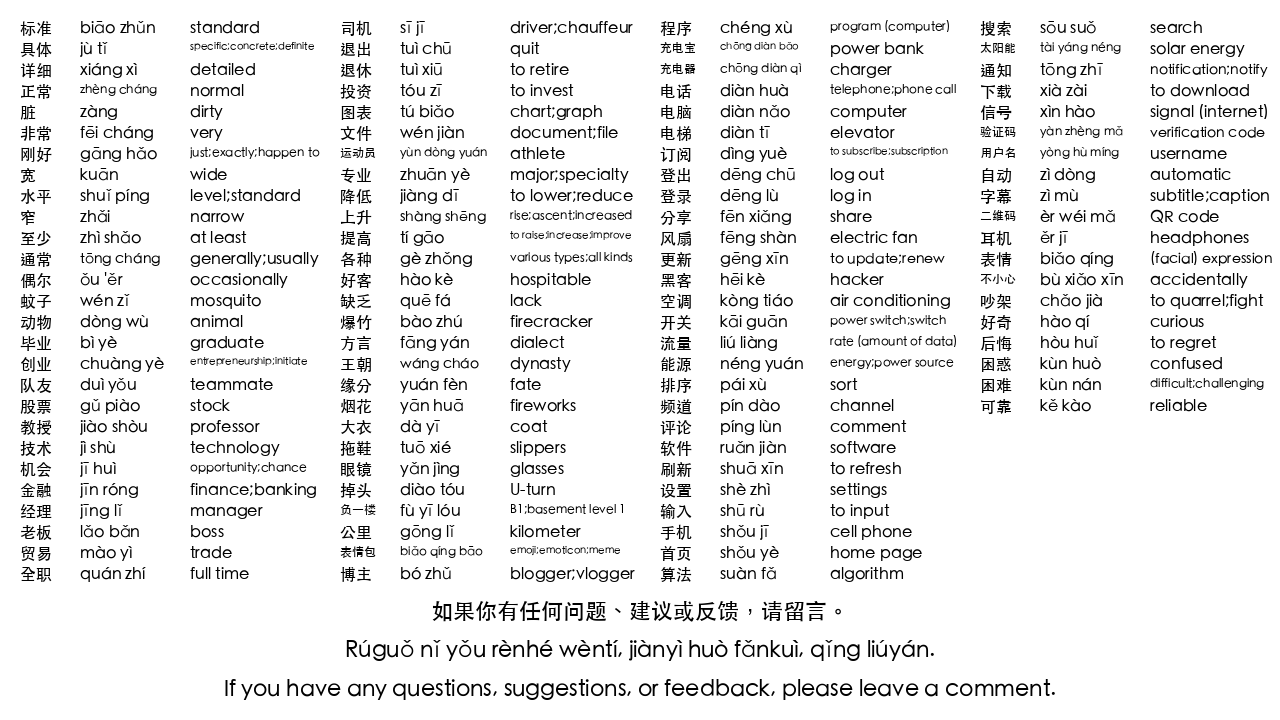

In [14]:
# Create slide with all words
# Audio: "here are the X words over the next X minutes"
ALL_WORDS_SLIDE_YTOP = 20
ALL_WORDS_SLIDE_YBOTTOM = 130
ALL_WORDS_SLIDE_XTOP = 20
ALL_WORDS_SLIDE_SPACING = 5
ALL_WORDS_SLIDE_FONT_SIZE = 16
ALL_WORDS_SLIDE_TEXT_FILL = 'black'
ALL_WORDS_SLIDE_TEXT_ALIGN = 'left'
ALL_WORDS_SLIDE_TEXT_COL_SPACE = 20
ALL_WORDS_SLIDE_TEXT_COL_SPACE_BIG = 20
ALL_WORDS_DEF_PARTS = {
    'chinese': {'x_offset': 0, 'x_max': 40, 'font_path': hanzi_font_path},
    'pinyin': {'x_offset': None, 'x_max': 90, 'font_path': hanzi_font_path},
    'english': {'x_offset': None, 'x_max': 130, 'font_path': hanzi_font_path},
}

# Derived
ALL_WORDS_SLIDE_YCHANGE = ALL_WORDS_SLIDE_FONT_SIZE + ALL_WORDS_SLIDE_SPACING
ALL_WORDS_DEF_PARTS['pinyin']['x_offset'] = ALL_WORDS_DEF_PARTS['chinese']['x_offset'] + ALL_WORDS_DEF_PARTS['chinese']['x_max'] + ALL_WORDS_SLIDE_TEXT_COL_SPACE
ALL_WORDS_DEF_PARTS['english']['x_offset'] = ALL_WORDS_DEF_PARTS['pinyin']['x_offset'] + ALL_WORDS_DEF_PARTS['pinyin']['x_max'] + ALL_WORDS_SLIDE_TEXT_COL_SPACE
ALL_WORDS_SLIDE_XCHANGE = ALL_WORDS_DEF_PARTS['english']['x_offset'] + ALL_WORDS_DEF_PARTS['english']['x_max'] + ALL_WORDS_SLIDE_TEXT_COL_SPACE_BIG

n_offsets = 0
last_y_offset_idx = 0
cur_y_offset = ALL_WORDS_SLIDE_YTOP
cur_x_offset = ALL_WORDS_SLIDE_XTOP
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    # Initialize image
    img = Image.new("RGB", BG_SIZE, color=BG_COLOR)
    draw = ImageDraw.Draw(img)
    df_all_words = df_audio_durations[rrow['recording_name']].dropna(subset='sum_theory').reset_index(drop=True)
    for idx, row in df_all_words.iterrows():
        for def_part, dp_settings in ALL_WORDS_DEF_PARTS.items():
            new_font_size = ALL_WORDS_SLIDE_FONT_SIZE
            font = ImageFont.truetype(dp_settings['font_path'], new_font_size)
            font_size_too_big = determine_if_text_size_too_big(row[def_part], font, line_length=dp_settings['x_max'])
            while font_size_too_big:
                new_font_size -= 2
                print(f'"{row[def_part]}" reduced font size to {new_font_size}')
                font = ImageFont.truetype(dp_settings['font_path'], new_font_size)
                font_size_too_big = determine_if_text_size_too_big(row[def_part], font, line_length=dp_settings['x_max'])
            
            # Compute current X and Y positions
            y_pos_v1 = (cur_y_offset + ALL_WORDS_SLIDE_YCHANGE*(idx - last_y_offset_idx))
            
            if y_pos_v1 > (BG_SIZE[1] - ALL_WORDS_SLIDE_YCHANGE - ALL_WORDS_SLIDE_YBOTTOM):
                n_offsets += 1
                last_y_offset_idx = idx
                cur_y_offset = ALL_WORDS_SLIDE_YTOP
                cur_x_offset += ALL_WORDS_SLIDE_XCHANGE

            x_pos = cur_x_offset + dp_settings['x_offset']
            y_pos_v2 = cur_y_offset + ALL_WORDS_SLIDE_YCHANGE*(idx - last_y_offset_idx)
            
            draw.text(
                xy=(x_pos, y_pos_v2), text=row[def_part], font=font
                , fill=ALL_WORDS_SLIDE_TEXT_FILL, spacing=0, align=ALL_WORDS_SLIDE_TEXT_ALIGN
                )

    # Write audio subtitles
    img_only_list_of_words = copy.copy(img)
    subtitle_text = f'{nonvocab_slides['end']['chinese']}\n{nonvocab_slides['end']['pinyin']}\n{nonvocab_slides['end']['english']}'
    subtitle_text_len = max([NONVOCAB_AUDIO_TEXT_FONT.getlength(x) for x in subtitle_text.split('\n')])
    draw.text(
        xy=(BG_SIZE[0]/2 - subtitle_text_len/2, NONVOCAB_AUDIO_TEXT_Y),
        text=subtitle_text,
        font=NONVOCAB_AUDIO_TEXT_FONT,
        fill=NONVOCAB_AUDIO_TEXT_FILL,
        spacing=NONVOCAB_AUDIO_TEXT_SPACING,
        align=NONVOCAB_AUDIO_TEXT_ALIGN,
        )
    
    img_file_path = f"{nonvocab_audio_path}{rrow['recording_name']}/end.png"
    img.save(img_file_path)
    my_img = ImageClip(img_file_path, duration=1).with_start(0)
my_img.display_in_notebook()

## 6d. All words slide

In [15]:
if 'word_list' in nonvocab_slides.keys():
    subtitle_text = f'{nonvocab_slides['word_list']['chinese']}\n{nonvocab_slides['word_list']['pinyin']}\n{nonvocab_slides['word_list']['english']}'
    subtitle_text_len = max([NONVOCAB_AUDIO_TEXT_FONT.getlength(x) for x in subtitle_text.split('\n')])
    draw_on_wordlist = ImageDraw.Draw(img_only_list_of_words)
    draw_on_wordlist.text(
        xy=(BG_SIZE[0]/2 - subtitle_text_len/2, NONVOCAB_AUDIO_TEXT_Y),
        text=subtitle_text,
        font=NONVOCAB_AUDIO_TEXT_FONT,
        fill=NONVOCAB_AUDIO_TEXT_FILL,
        spacing=NONVOCAB_AUDIO_TEXT_SPACING,
        align=NONVOCAB_AUDIO_TEXT_ALIGN,
        )

    img_file_path = f"{nonvocab_audio_path}{rrow['recording_name']}/word_list.png"
    img_only_list_of_words.save(img_file_path)
    my_img = ImageClip(img_file_path, duration=1).with_start(0)
    my_img.display_in_notebook()

## 6f. icon slide

In [21]:
# Icon slide settings
file_suffix = '_slide_all'
icon_word = '通知'
icon_color_hex = "#1E90FF"
icon_border_width = 30

# Create blue background
img = Image.new("RGB", (BG_SIZE[0] + icon_border_width*2, BG_SIZE[1] + icon_border_width*2), color=icon_color_hex)

# Open the PNG image to be inserted
# Paste the overlay image onto the background image
overlay_image = Image.open(f"audio_files/img_for_video/{rrow['recording_id']}/{icon_word}_{file_suffix}.png")
if overlay_image.mode != 'RGBA':
    overlay_image = overlay_image.convert('RGBA')
img.paste(overlay_image, (icon_border_width, icon_border_width), overlay_image)
img.save(f'{nonvocab_audio_path}{rrow['recording_name']}/icon.png')

# 7. Create video
## 7a. Combine clips

In [17]:
# Display static clips as desired
clips_all = clips[rrow['recording_name']].copy()
for cs_name, cs_set in nonvocab_slides.items():
    image_with_duration = ImageClip(f'{nonvocab_audio_path}{rrow['recording_name']}/{cs_name}.png', duration=cs_set['duration']).with_start(cs_set['start'])
    if cs_set['clip_index'] >= 0:
        clips_all.insert(cs_set['clip_index'], image_with_duration)
    else:
        clips_all.append(image_with_duration)
print(len(clips_all))
clips_all[:5]

102


## 7b. Create whole video

In [18]:
# Compare durations of audio and video
audio = AudioFileClip(f"{nonvocab_audio_path}{rrow['recording_name']}/audio.mp3")
all_clips_duration = sum(clip.duration for clip in clips_all)
audio_video_duration_diff = audio.duration - all_clips_duration
print(f"{rrow['recording_name']}: audio: {audio.duration:.3f}s, video: {all_clips_duration:.3f}s; difference: {audio_video_duration_diff:.3f}s")
if audio_video_duration_diff > 0.3:
    raise ValueError('Difference between audio and video durations too high.')

for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    create_full_video_file(clips_all, rrow, nonvocab_audio_path)

0925_chinese_only_word_twice__one_hundred_words: audio: 371.160s, video: 371.117s; difference: 0.043s
MoviePy - Building video audio_files/files_by_video/0925_chinese_only_word_twice__one_hundred_words/video.mp4.
MoviePy - Writing audio in videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video audio_files/files_by_video/0925_chinese_only_word_twice__one_hundred_words/video.mp4



MoviePy - Done !
MoviePy - video ready audio_files/files_by_video/0925_chinese_only_word_twice__one_hundred_words/video.mp4
